In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from prettytable import PrettyTable 

In [2]:
%matplotlib inline
sns.set_theme(style="whitegrid")

# Data Preprocessing

In [3]:
data_params = pd.read_csv("params_res_example.csv", index_col=0)
data_dyn = pd.read_csv("dyn_res_example.csv", index_col=0)

In [4]:
data_params = np.asarray(data_params)
data_dyn = np.asarray(data_dyn.T)

Text(0, 0.5, 'infected cases')

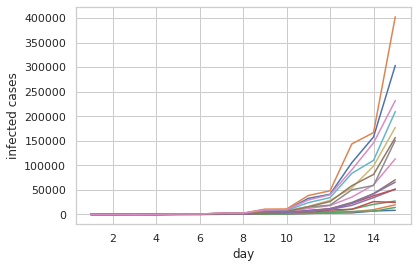

In [5]:
x = [i for i in range(1, len(data_dyn[0])+1)]

for i in range(len(data_dyn)):
    plt.plot(x, data_dyn[i], label='linear')
    
plt.xlabel('day')  
plt.ylabel('infected cases')  

### Loading models 

In [6]:
# RQ kernel
gpr_rq = joblib.load('gpr_ABM_RQ_2.pkl')

# RBF + RQ kernel
gpr_add = joblib.load('gpr_ABM_ADD_2.pkl')

# Dynamics estimation

In [7]:
pred_rq = gpr_rq.predict(data_params, return_std=False)
pred_add = gpr_add.predict(data_params, return_std=False)

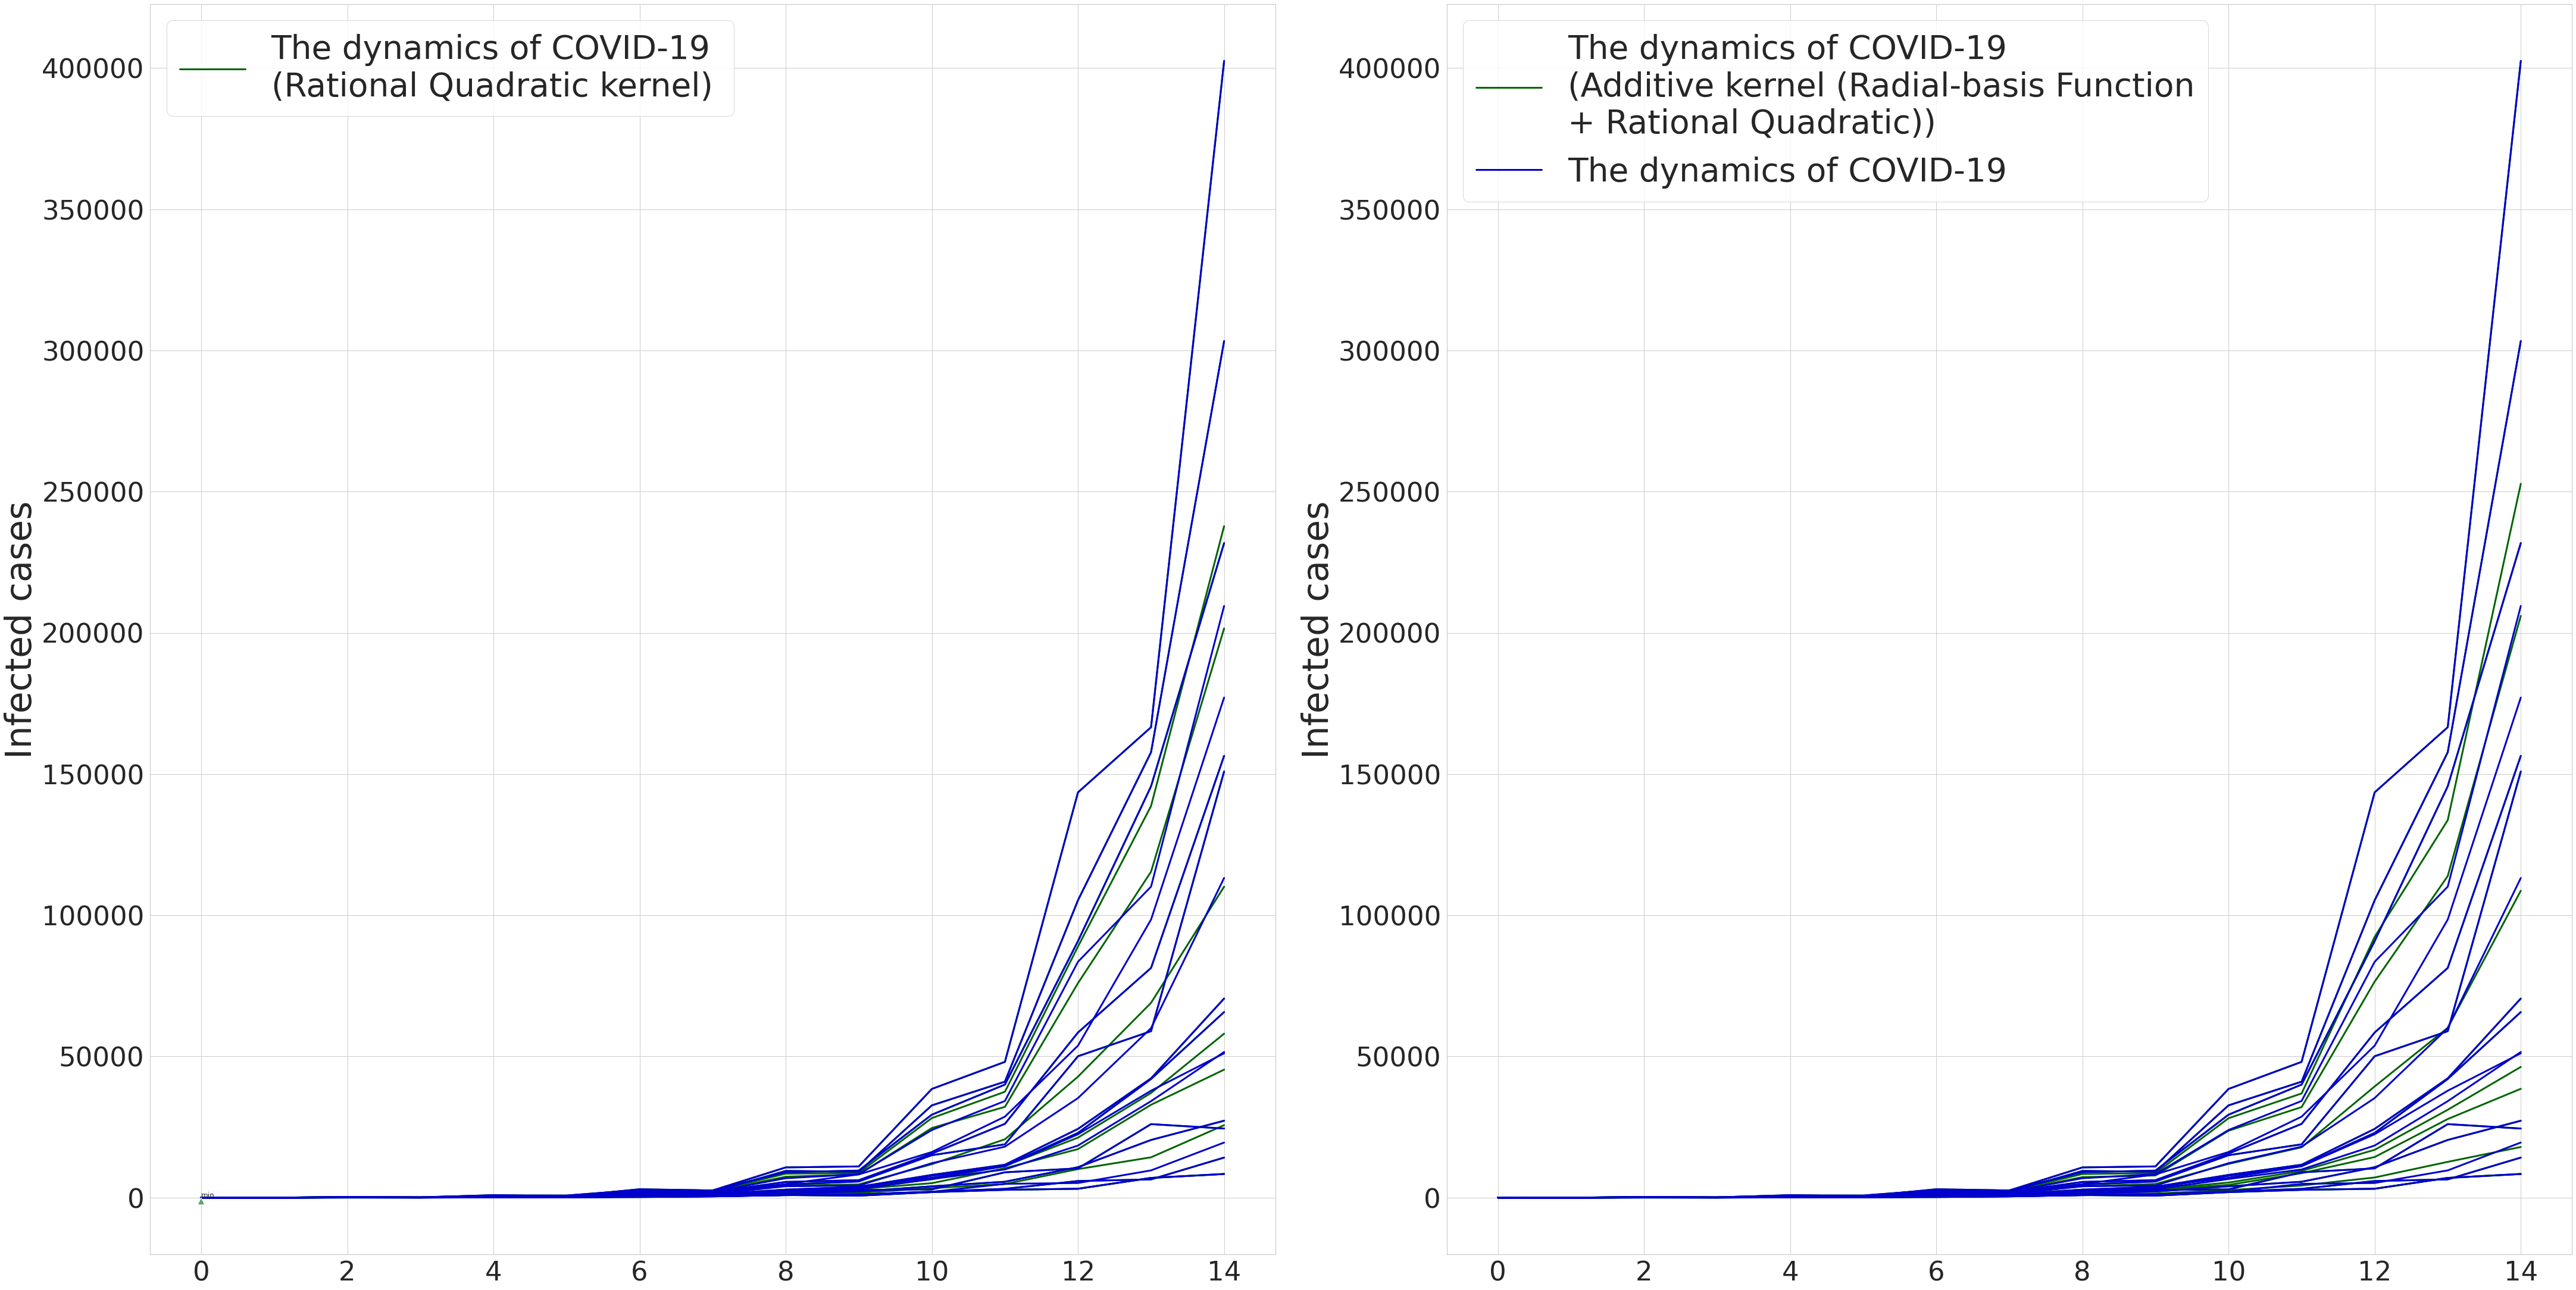

In [8]:
# plotting the results

fig, axs = plt.subplots(1, 2, figsize=(60, 30), layout='constrained')

axs[0].plot(pred_rq[0], linewidth = 3, color='darkgreen',
            label='The dynamics of COVID-19 \n'+
            '(Rational Quadratic kernel)')
for i in range(len(pred_rq)):
    axs[0].plot(pred_rq[i], linewidth = 3, color='darkgreen')

axs[0].set_ylabel('Infected cases', fontsize=60)
axs[0].legend(prop={'size': 55})

axs[0].annotate('min', xy=(0, 0),  xycoords='data',
            xytext=(0, 10), textcoords='data',
            arrowprops=dict(facecolor='g'))

axs[0].plot(data_dyn[0], linewidth = 3, color='mediumblue', label='The dynamics of COVID-19')    
for i in range(1, len(data_dyn)):
    axs[0].plot(data_dyn[i], linewidth = 3, color='mediumblue')


axs[1].plot(pred_add[0], linewidth = 3, color='darkgreen', 
            label='The dynamics of COVID-19 \n'+
            '(Additive kernel (Radial-basis Function\n'+
            '+ Rational Quadratic))')
for i in range(len(pred_add)):
    axs[1].plot(pred_add[i], linewidth = 3, color='darkgreen')
    
axs[1].plot(data_dyn[0], linewidth = 3, color='mediumblue', label='The dynamics of COVID-19')    
for i in range(1, len(data_dyn)):
    axs[1].plot(data_dyn[i], linewidth = 3, color='mediumblue')

axs[1].set_ylabel('Infected cases', fontsize=60)
axs[1].legend(prop={'size': 55})

axs[0].grid(True)
axs[1].grid(True)

axs[0].tick_params(axis='both', which='major', labelsize=45)
axs[1].tick_params(axis='both', which='major', labelsize=45)

In [9]:
def metrics_func(params, y_pred, y_test):
    metrics_col = ['inf_init', 'alpha', 'lambda', 'MAE', 'R^2']
    metrics_df = pd.DataFrame(columns=metrics_col)

    for i in range(len(y_test)):
        # mae
        mae = 0
        for j in range(len(y_pred[i])):
            mae += abs(y_test[i][j]-y_pred[i][j])
        mae /= len(y_pred[i])

        # r_squared
        tmp1 = 0
        tmp2 = 0
        for j in range(len(y_pred[i])):
            tmp1 += (y_pred[i][j] - y_test[i][j]) ** 2
            tmp2 += (y_test[i][j] - np.mean(y_test[j])) ** 2
        r_squared = 1 - tmp1 / tmp2
    
        tmp_df = pd.DataFrame({'inf_init': [params[i][0]],
                               'alpha': [params[i][1]],
                               'lambda': [params[i][2]],
                               'MAE': [round(mae, 5)],
                               'R^2': [round(r_squared, 5)]})
    
        metrics_df = pd.concat([metrics_df, tmp_df], ignore_index=True, axis=0)
    
    return metrics_df

In [10]:
metrics_rq = metrics_func(data_params, pred_rq, data_dyn)
metrics_add = metrics_func(data_params, pred_add, data_dyn)

In [11]:
mean_metrics_rq = metrics_rq.mean()
mean_metrics_add = metrics_add.mean()

In [12]:
print("Mean metrics")

print('Rational Quadratic kernel:')
x = PrettyTable()

x.field_names = ["Metric", "Value"]
x.add_row([f"MAE", round(mean_metrics_rq['MAE'], 5)])
x.add_row([f"R-squared", round(mean_metrics_rq['R^2'], 5)])

print(x)

print('Additive kernel:')
x = PrettyTable()

x.field_names = ["Metric", "Value"]
x.add_row([f"MAE", round(mean_metrics_add['MAE'], 5)])
x.add_row([f"R-squared", round(mean_metrics_add['R^2'], 5)])

print(x)

Mean metrics
Rational Quadratic kernel:
+-----------+-----------+
|   Metric  |   Value   |
+-----------+-----------+
|    MAE    | 897.30704 |
| R-squared |  0.99399  |
+-----------+-----------+
Additive kernel:
+-----------+-----------+
|   Metric  |   Value   |
+-----------+-----------+
|    MAE    | 922.62257 |
| R-squared |  0.99222  |
+-----------+-----------+
